# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import loadmat
from numpy import linalg as la
# from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def NGD3L1D_STK(xAxis, tAxis, sigma_dict, tPara_ict, spaceDivideStep = 1, timeDivideStep = 60):
# divideStep upsample rate
# tPara_dict must include these temporal parameters: alpha, beta, gamma, g, h, l 
    dx = np.mean(np.diff(xAxis)) / spaceDivideStep
    xAxis = AxisByHalfLen(xAxis[-1], dx)
    gaussK = {} # Gassian Kernel
    for (key,value) in sigma_dict.items():
        halfKLen = min( value*8, xAxis[-1])
        kAxis = AxisByHalfLen(halfKLen, dx)
        gaussK[key] = Gaussian_filter_1d(kAxis,value)

    dt = np.mean(np.diff(tAxis)) / timeDivideStep
    tAxis = np.arange(0, tAxis[-1]+dt, dt)
    stimulus = np.zeros([len(tAxis), len(xAxis)])
    if "tau_delay" in tPara_ict:
        delayed_delta = tAxis /tPara_dict['tau_delay']/tPara_dict['tau_delay'] *np.exp(-tAxis/tPara_dict['tau_delay']) *dt
        stimulus[:,int(len(xAxis)/2)] = delayed_delta
    else:
        stimulus[0,int(len(xAxis)/2)] = 1

    for key in ['alpha','beta','gamma','m','n','g','h','l']: # initialize tPara_ict
        if not key in tPara_ict.keys(): 
            tPara_ict[key] = 1

    z = np.zeros_like(stimulus)
    y = np.zeros_like(stimulus)
    w = np.zeros_like(stimulus)

    for i in np.arange(len(tAxis)-1):
        R = {'s2y':stimulus[i,:], 'y2z':y[i,:], 'y2w':y[i,:], 'z2y':z[i,:], 'z2w':z[i,:]} # initialization
        for key in R.keys():
            if key in gaussK:    R[key] = np.convolve(R[key],gaussK[key],'same')*dx

        dy = (-tPara_dict['alpha']*y[i,:] + tPara_dict['m']*R['s2y'] - tPara_dict['n']*R['z2y'])*dt
        dz = (-tPara_dict['beta'] *z[i,:] + tPara_dict['g']*R['y2z']                           )*dt
        dw = (-tPara_dict['gamma']*w[i,:] + tPara_dict['h']*R['y2w'] - tPara_dict['l']*R['z2w'])*dt

        y[i+1,:] = (y[i,:]+dy)
        z[i+1,:] = (z[i,:]+dz)
        w[i+1,:] = (w[i,:]+dw)
    actual_xAxisIndex = np.append( np.arange(int(len(xAxis)/2), -1, -spaceDivideStep)[:0:-1], np.arange(int(len(xAxis)/2), len(xAxis), spaceDivideStep) )
    y = y[::timeDivideStep, actual_xAxisIndex]/dx/dt #
    z = z[::timeDivideStep, actual_xAxisIndex]/dx/dt
    w = w[::timeDivideStep, actual_xAxisIndex]/dx/dt

    return w, z, y

def AxisByHalfLen(halfLen, dx):
    axis = np.arange(0, halfLen+dx, dx)
    return np.append(-1*axis[:0:-1], axis)


# Set Parameter

## Exp

In [3]:
# temporal
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

tPara_dict = {
'alpha':1.302408,
'beta':13.024075,
'gamma':34.901452,
'g':460.016331,
'l':0.021331,
'tau_delay':0.028650,
'm':127.832600} # m can be nagative for off cell

# spatial
sigma_dict = dict()
sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 
sigma_dict['y2z'] = 0.05*sigma_dict['y2w']   # has to be small enough

dx = 0.005 # OLED pixel2micro = 7.6
hXstep =  int(2 /dx) # Half length of xais, (mm)
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

## By hand

In [4]:
# # temporal
# dt = 0.01 #large dt will cause  overflow
# Tstep = int(1./dt)
# TKtaxis = np.arange(Tstep)*dt

# tPara_dict = {
# 'alpha':40,
# 'beta':2,
# 'gamma':100,
# 'm':40,
# 'n':200,
# 'g':2,
# 'h':50,
# 'l':50,
# 'tau_delay':0.02} # m can be nagative for off cell

# # spatial
# sigma_dict = dict()
# sigma_dict['y2w'] = 0.20426678569344126 *1.1 # mm from exp data (RF radius = 1.5*sigma)
# # sigma_dict['y2z'] =10/9*sigma_dict['y2w'] 
# sigma_dict['z2w'] = 1.1*sigma_dict['y2w'] 

# dx = 0.005 # OLED pixel2micro = 7.6
# hXstep =  int(2 /dx) # Half length of xais, (mm)
# # hXstep =  int(1.015 /dx) # range of Checkboard, 1.5*sqrt(2)/2
# SKxaxis = np.arange(-hXstep,hXstep+1)*dx

# STK

In [5]:
Delta_output_w, zts, Delta_output_y = NGD3L1D_STK(SKxaxis, TKtaxis, sigma_dict, tPara_dict)

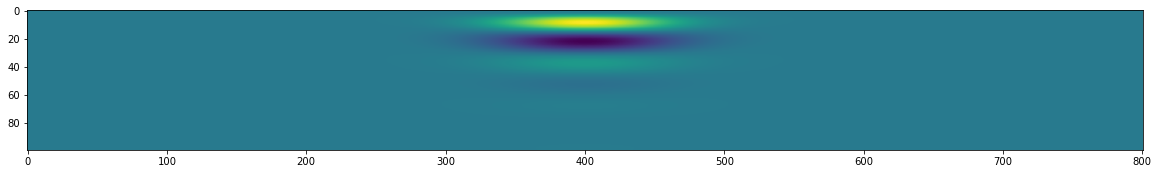

In [6]:
plt.imshow(Delta_output_w)
plt.gcf().set_size_inches(20, 5)


In [7]:
delSTK = Delta_output_w

In [8]:
iSK = np.sum(delSTK, axis = 0)*dt
iTK = np.sum(delSTK, axis = 1)*dx
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis, :]
SeSTK = SeSTK/np.max(SeSTK)*np.max(delSTK)

# SVD

In [9]:
U,sigma,VT=la.svd(delSTK)

In [10]:
print((sigma/sum(sigma))[:5])
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]
        

SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]*sigma[0]

[9.61498634e-01 3.84461338e-02 5.38562577e-05 1.36575741e-06
 9.63243521e-09]


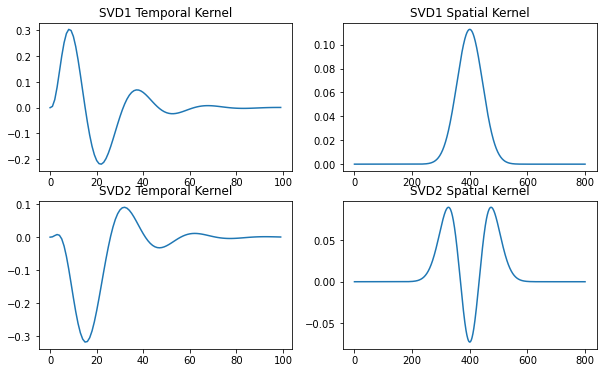

In [11]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(10, 6)

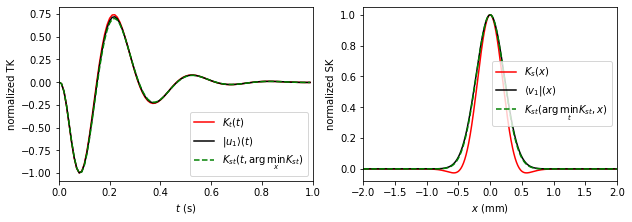

In [12]:
fig, ax = plt.subplots(1,2)
ax[1].plot(SKxaxis, iSK/np.max(iSK), 'r',label=r'$K_s(x)$')
ax[1].plot(SKxaxis, VT[0,:]/np.max(VT[0,:]), 'k',label=r'$\left\langle {v_1} \right|(x)$')
ax[1].plot(SKxaxis, delSTK[np.where(delSTK == np.max(delSTK))[0][0], :]/np.max(delSTK), 'g--',label=r'$K_{st}(\arg\min_{t} K_{st}, x)$')
ax[1].legend(loc='best')
ax[1].set_ylabel('normalized SK')
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_xlim([-2,2])

ax[0].plot(TKtaxis, -iTK/np.max(iTK), 'r',label=r'$K_t(t)$')
ax[0].plot(TKtaxis, -U[:,0]/np.max(U[:,0]), 'k', label=r'$\left| u_1 \right\rangle(t)$')
ax[0].plot(TKtaxis, -delSTK[:, np.where(delSTK == np.max(delSTK))[1][0]]/np.max(delSTK), 'g--',label=r'$K_{st}(t, \arg\min_{x} K_{st})$')
ax[0].set_xlabel(r'$t$ (s)')
ax[0].set_ylabel('normalized TK')
ax[0].set_xlim([0,1])
# ax[0].plot(TKtaxis, U[:,1]/np.max(U[:,1]) *sigma[1]/sigma[0], label='u2')

ax[0].legend(loc='best')
fig.set_size_inches(10,3.2)

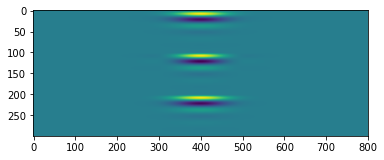

In [13]:
plt.imshow(np.vstack((delSTK,SeSTK,SVDSTK)))

# Steady State of Constant Moving Bar
SK of moving frame

In [14]:
def StadyState_ConstMoveDelta(v, Kernel, dx, dt): 
    v = v*dt/dx #dimensionless v
    if Kernel.shape[1]%2 == 0: return
    addlen = int(v*(Kernel.shape[0]-1))
    
    xaxis = np.arange(-int(Kernel.shape[1]/2)-addlen, int(Kernel.shape[1]/2)+1)*dx
    last_mb_y = np.zeros_like(xaxis)
    for k in range(Kernel.shape[0]):
        shift = int(v*k)
        last_mb_y += np.hstack((np.zeros(addlen-shift) ,Kernel[k,:], np.zeros(shift)))*dt
    return last_mb_y, xaxis

In [15]:
def SquareWave(width, dx): #width in mm
    halfWidth = int( (width/dx-1)/2 + 0.5) # halfWidth is dimensionless
    return np.ones(2*halfWidth+1), (2*halfWidth+1)*dx # return a square wave and the actual width of it

def GaussianWave(sigma, dx): # sigma is dimensionless
    s = sigma/dx # s is dimensionless
    xaxis = np.arange(-10*int(s), 10*int(s)+1)
    return (np.exp(-(xaxis/s)**2/2)) # return a Gaussian wave

def MasterConvolve(master, servant):
    if len(master)>=len(servant):
        return np.convolve(master, servant, 'same')
    else:
        output = np.convolve(master, servant, 'full')
        sHalfLen = int(len(servant)/2)
        return output[sHalfLen:-sHalfLen]

## Control: v,  Independent: hw and $\sigma$

In [16]:
v = 0.44 #mm/s #berry
delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
SeSKvp,  xaxis = StadyState_ConstMoveDelta(v, SeSTK,  dx, dt)
SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


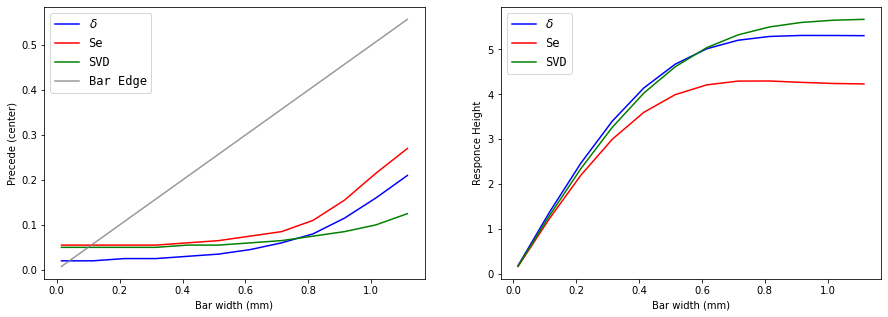

In [17]:
fig, ax = plt.subplots(1,2)
width_list = np.arange(10, 1200, 100)*1E-3 # it is 0.129 mm in our exp. and 0.133 mm in Berry's.
squareWave_list = np.array([SquareWave(width, dx) for width in width_list])
effWidth_list = squareWave_list[:, 1]
squareWave_list = squareWave_list[:, 0]

del_hw2y = np.array([np.convolve(delSKvp, squareWave, 'same') for squareWave in squareWave_list])
se_hw2y  = np.array([np.convolve(SeSKvp , squareWave, 'same') for squareWave in squareWave_list])
svd_hw2y = np.array([np.convolve(SVDSKvp, squareWave, 'same') for squareWave in squareWave_list])


ax[0].plot(effWidth_list, xaxis[np.argmax(del_hw2y, axis = 1)], c='b')
ax[0].plot(effWidth_list, xaxis[np.argmax(se_hw2y, axis = 1)] , c='r')
ax[0].plot(effWidth_list, xaxis[np.argmax(svd_hw2y, axis = 1)], c='g')
ax[0].set_ylabel('Precede (center)')
ax[0].plot([effWidth_list[0], effWidth_list[-1]], [0.5*effWidth_list[0], 0.5*effWidth_list[-1]], c = 'gray', alpha = 0.8)
ax[1].plot(effWidth_list, np.max(del_hw2y, axis = 1), c='b')
ax[1].plot(effWidth_list, np.max(se_hw2y, axis = 1), c='r')
ax[1].plot(effWidth_list, np.max(svd_hw2y, axis = 1), c='g')
ax[1].set_ylabel('Responce Height')
for axi in ax:
    axi.set_xlabel('Bar width (mm)')
    axi.legend((r'$\delta$', 'Se', 'SVD', 'Bar Edge'),loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15,5)

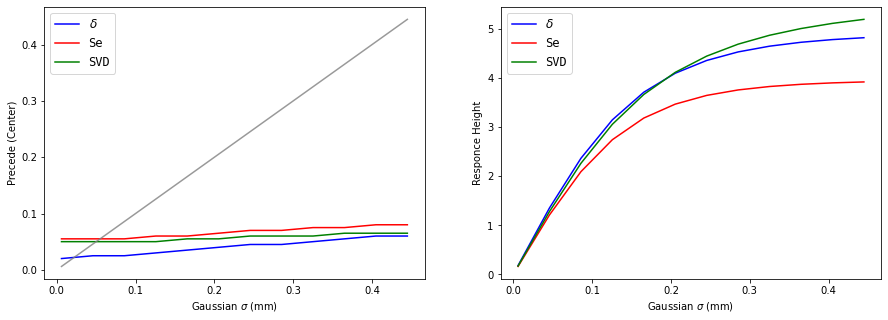

In [18]:
fig, ax = plt.subplots(1,2)
# sigma_list = np.arange(1,55,0.5)*dx
sigma_list = effWidth_list/np.sqrt(2*np.pi) # same power (integrate intensity alone space)
guassWave_list = [GaussianWave(sigma, dx) for sigma in sigma_list]

del_sigma2y = np.array([MasterConvolve(delSKvp, guassWave) for guassWave in guassWave_list])
se_sigma2y  = np.array([MasterConvolve(SeSKvp , guassWave) for guassWave in guassWave_list])
svd_sigma2y = np.array([MasterConvolve(SVDSKvp, guassWave) for guassWave in guassWave_list])


ax[0].plot(sigma_list, xaxis[np.argmax(del_sigma2y, axis = 1)], c='b')
ax[0].plot(sigma_list, xaxis[np.argmax(se_sigma2y, axis = 1)], c='r')
ax[0].plot(sigma_list, xaxis[np.argmax(svd_sigma2y, axis = 1)], c='g')
ax[0].set_ylabel('Precede (Center)')
# ax[0].axhline(0, c = 'gray', alpha = 0.8)
ax[0].plot([sigma_list[0], sigma_list[-1]], [sigma_list[0], sigma_list[-1]], c = 'gray', alpha = 0.8)
ax[1].plot(sigma_list, np.max(del_sigma2y, axis = 1), c='b')
ax[1].plot(sigma_list, np.max(se_sigma2y, axis = 1),  c='r')
ax[1].plot(sigma_list, np.max(svd_sigma2y, axis = 1), c='g')
ax[1].set_ylabel('Responce Height')
for axi in ax:
    axi.set_xlabel(r'Gaussian $\sigma$ (mm)')
    axi.legend((r'$\delta$', 'Se', 'SVD'),loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15,5)

## Control: hw and $\sigma$,  Independent: v

Effective width = 0.135


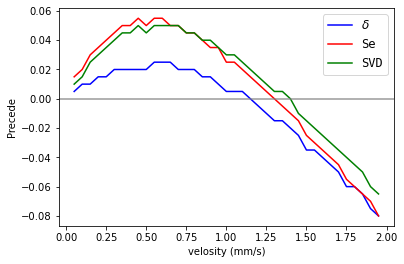

In [19]:
width = 0.133 #mm
squareWave, width = SquareWave(width, dx)
print('Effective width = '+str(width))
del_preceed = []
Se_preceed = []
SVD_preceed = []
v_list = np.arange(0.05,2,0.05)
for v in v_list:
    delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
    delSKvphw = np.convolve(delSKvp , squareWave, 'same')
    del_preceed.append(xaxis[np.argmax(delSKvphw)])
    
    SeSKvp, xaxis = StadyState_ConstMoveDelta(v, SeSTK, dx, dt)
    SeSKvphw = np.convolve(SeSKvp , squareWave, 'same')
    Se_preceed.append(xaxis[np.argmax(SeSKvphw)])
    
    SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)
    SVDSKvphw = np.convolve(SVDSKvp , squareWave, 'same')
    SVD_preceed.append(xaxis[np.argmax(SVDSKvphw)])
    
plt.plot(v_list, del_preceed, c='b')
plt.plot(v_list, Se_preceed,  c='r')
plt.plot(v_list, SVD_preceed, c='g')
plt.axhline(0, c = 'gray', alpha = 0.8)
plt.ylabel('Precede')
plt.xlabel(r'velosity (mm/s)')
plt.legend((r'$\delta$', 'Se', 'SVD'),loc='best', prop={'size': 'large', 'family': 'monospace'})

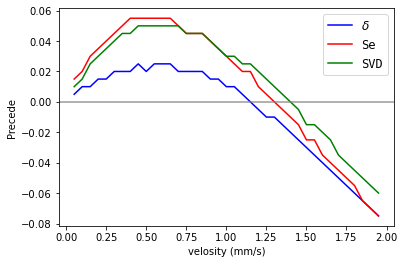

In [20]:
sigma = width/np.sqrt(2*np.pi)
guassWave = GaussianWave(sigma, dx)
del_preceed = []
Se_preceed = []
SVD_preceed = []
for v in v_list:
    delSKvp, xaxis = StadyState_ConstMoveDelta(v, delSTK, dx, dt)
    delSKvpsig = MasterConvolve(delSKvp, guassWave)
    del_preceed.append(xaxis[np.argmax(delSKvpsig)])
    SeSKvp, xaxis = StadyState_ConstMoveDelta(v, SeSTK, dx, dt)
    SeSKvpsig = MasterConvolve(SeSKvp, guassWave)
    Se_preceed.append(xaxis[np.argmax(SeSKvpsig)])
    SVDSKvp, xaxis = StadyState_ConstMoveDelta(v, SVDSTK, dx, dt)
    SVDSKvpsig = MasterConvolve(SVDSKvp, guassWave)
    SVD_preceed.append(xaxis[np.argmax(SVDSKvpsig)])
    
plt.plot(v_list, del_preceed, c='b')
plt.plot(v_list, Se_preceed, c='r')
plt.plot(v_list, SVD_preceed, c='g')
plt.axhline(0, c = 'gray', alpha = 0.8)
plt.ylabel('Precede')
plt.xlabel(r'velosity (mm/s)')
plt.legend((r'$\delta$', 'Se', 'SVD'),loc='best', prop={'size': 'large', 'family': 'monospace'})

## plot specific

In [21]:
def plotSquareWave(ax, xaxis, shortSquareWave):
    hwStep = int((len(shortSquareWave)-1)/2)
    centerIndex = np.squeeze(np.where(xaxis==0))
    squareWave = np.zeros_like(xaxis)
    squareWave[centerIndex-hwStep:centerIndex+hwStep+1] = 1
    ax.plot(xaxis, squareWave)
def plotGaussWave(ax, guassWave,  dx):
    hwStep = int((len(guassWave)-1)/2)
    xaxis = np.arange(-hwStep,hwStep+1)*dx
    ax.plot(xaxis, guassWave)

Effective width = 0.135


(-1.0, 1.0)

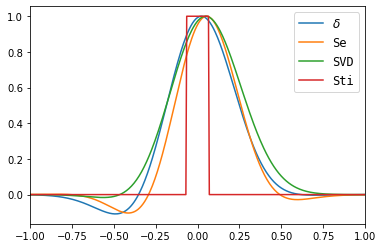

In [22]:
v = 0.44
fig, ax = plt.subplots()

width = 0.133
squareWave, width = SquareWave(width, dx)
print('Effective width = '+str(width))

c = 0
for STK in [delSTK, SeSTK, SVDSTK]:
    SKvp, xaxis = StadyState_ConstMoveDelta(v, STK, dx, dt)
    SKvp = np.convolve(SKvp, squareWave, 'same')
    ax.plot(xaxis, SKvp/max(SKvp))
plotSquareWave(ax, xaxis, squareWave)
ax.legend((r'$\delta$', 'Se', 'SVD', 'Sti'),loc='best', prop={'size': 'large', 'family': 'monospace'})

plt.xlim(-1,1)

(-1.0, 1.0)

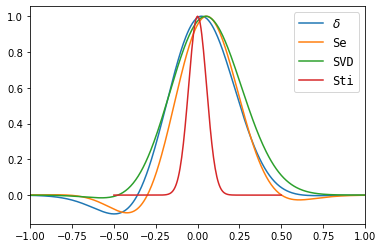

In [23]:
sigma = width/np.sqrt(2*np.pi)
guassWave = GaussianWave(sigma, dx)
fig, ax = plt.subplots()
c = 0
for STK in [delSTK, SeSTK, SVDSTK]:
    SKvp, xaxis = StadyState_ConstMoveDelta(v, STK, dx, dt)
    
    SKvp = MasterConvolve(SKvp, guassWave)
    ax.plot(xaxis, SKvp/max(SKvp))
plotGaussWave(ax, guassWave,  dx)
ax.legend((r'$\delta$', 'Se', 'SVD', 'Sti'),loc='best', prop={'size': 'large', 'family': 'monospace'})

plt.xlim(-1,1)